# РАЗРАБОТКА ПРОСТОЙ МОДЕЛИ РАСПОЗНАВАНИЯ ЯЗЫКОВЫХ КОМАНД

## Курсовой проект
## Гаврилюк Р. И., ПО-3

## End-to-end Automatic Speech Recognition, ASR
---

<img src="images/pipeline.png">

- [**ШАГ 0**](#step0): Описание и формирования исходных данных

- [**ШАГ 1**](#step1): Предварительная обработка входных данных. Преобразование необработанного звука в нормализованную спектрограмму.

- [**ШАГ 2**](#step2): Акустическая модель. На вход подаются обработанные звуковые сигналы. На выходе формируется распределение вероятностей по всем потенциальным транскрипциям.
Разрабатываемая модель основана на исследованиях Baidu's «Deep Speech 2: End-to-End Speech Recognition in English and Mandarin», но имеет упрощенную структуру (рис. 2.2).

- [**ШАГ 3**](#step3): Формирование прогнозируемой транскрипции разговорного языка. Конвейер получает на вход выходные данные акустической модели и возвращает прогнозируемую транскрипцию.

- [**ВЫВОД**](#conclusion)

In [ ]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
import tensorflow as tf 
from tensorflow.python.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

<a id='step0'></a>
## ШАГ 0: Описание и формирование исходных данных
В качестве обучающей выборки используется датасет **Librispeech**, который в общей сложности содержит тысячу часов английской речи с частотой 16 кГц, собранных из аудиокниг. Обучение и проверка проводились на выборках по 5.4 часа каждая. Для обучающей выборки были сформированы файлы описания.

Для формирования исходных данных были использованы 2 скрипта:
- `convert_flac_to_wav.py` - для преобразования аудиофайлов с расширением .flac в аудиофайлы с расширением .wav.
- `create_desc_json.py` - для формирования файлов описания обучающей выборки, которые содержат относительный путь к аудиофайлам, их продолжительность и расшифровку.

<a id='step1'></a>
## ШАГ 1: Предварительная обработка входных данных.

Преобразование необработанного звука, подаваемого на вход, в мел-спектрограмму.
Для наглядности сформируем график мел-спектрограммы (по вертикали - время, по горизонтали - частота).

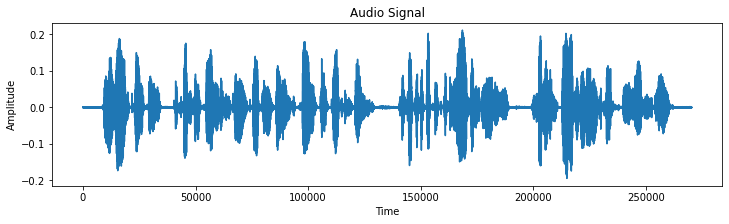

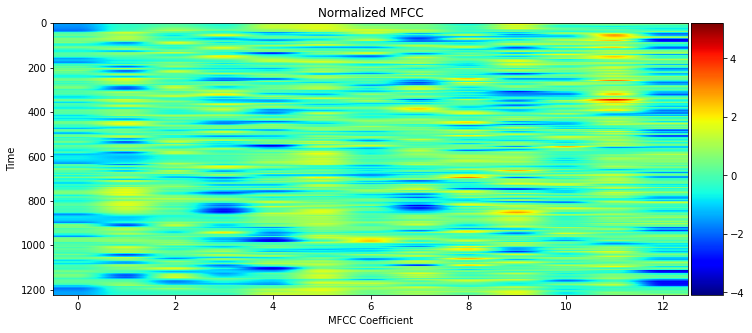

In [69]:
from plot_utils import plot_mfcc_feature
from plot_utils import plot_raw_audio

audio_path = "777-126732-0007.wav"

# plot audio signal
plot_raw_audio(audio_path)

# plot normalized mel-spectrogram
plot_mfcc_feature(audio_path)

<a id='step2'></a>
## ШАГ 2: Акустическая модель


На вход подаются обработанные звуковые сигналы. На выходе формируется распределение вероятностей по всем потенциальным транскрипциям.
Разрабатываемая модель основана на исследованиях Baidu's «Deep Speech 2: End-to-End Speech Recognition in English and Mandarin», но имеет упрощенную структуру.

<img src="images/my_model.png">

1.	Входные данные (Input) – необработанные звуковые сигналы.
2.	1D сверточный слой (CNN) преобразует звуковые данные в одномерный тензор.
3.	Пакетная нормализация (Batch normalization) выравнивает дисперсию звуковых сигналов, что также должно сократить время обучения и привести к более быстрой сходимости, требуя меньшего количества слоев, чем ненормализованные данные.
4.	Исключение (Dropout) используется для уменьшения переобучения модели.
5.	4 слоя двунаправленных рекуррентных нейронных сетей (Bidirectional RNN) с пакетной нормализацией и исключением на крайних слоях. С помощью двунаправленности увеличивается объем информации, доступной для рекуррентной сети за счет связывания текущего состояния с предыдущим и следующим. Наличие данной информации помогает сети делать более точные прогнозы.
6.	Распределенный по времени слой (TimeDistributed Dense), применяемый к конечному слою нормализации. Он применяет слой к каждому временному срезу звуковой волны. Входные данные в модель являются последовательностями. Для достижения более точной модели каждая часть последовательности должна быть рассмотрена, что позволяет сделать распределенный во времени слой. 
7.	Слой активации Softmax применяется к модели для классификации каждого из символов. Задача модели состояла в том, чтобы классифицировать каждую из временных звуковых последовательностей на символы. Функция softmax была разработана для того, чтобы хорошо работать при категоризации входных данных. Следовательно, функция softmax была подходящим решением для активационного слоя модели.
Softmax имеет 29 выходных классов: 26 английских букв, пробел, апостроф и пустой символ.

In [61]:
from sample_models import *
model_end = final_model(input_dim=13,
                        filters=200,
                        kernel_size=11,
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 1200)        3844800   
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 1200)        4800      
_________________________________________________________________
bidirectional_37 (Bidirectio (None, None, 800)         5123200   
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 800)       

## Обучение модели
После обучения модель сохраняется в HDF5 файл `model_end.h5`, история потерь in `model_end.pickle`.

In [3]:
from train_utils import train_model
train_model(input_to_softmax=model_end,
            pickle_path='model_final_2020.pickle',
            save_model_path='model_final_2020.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
106/106 [==============================] - 9882s 93s/step - loss: 241.4024 - val_loss: 234.7690
Epoch 2/10
106/106 [==============================] - 11376s 107s/step - loss: 166.2667 - val_loss: 210.4601
Epoch 3/10
106/106 [==============================] - 12330s 116s/step - loss: 131.8326 - val_loss: 191.6529
Epoch 4/10
106/106 [==============================] - 12962s 122s/step - loss: 113.4372 - val_loss: 123.2784
Epoch 5/10
106/106 [==============================] - 12532s 118s/step - loss: 100.4450 - val_loss: 110.9859
Epoch 6/10
106/106 [==============================] - 12495s 118s/step - loss: 89.6021 - val_loss: 109.2839
Epoch 7/10
106/106 [==============================] - 14212s 134s/step - loss: 80.1667 - val_loss: 108.8531
Epoch 8/10
106/106 [==============================] - 12218s 115s/step - loss: 71.5571 - val_loss: 106.6129
Epoch 9/10
106/106 [==============================] - 126

### График функции потерь для обучения и прогнозирования

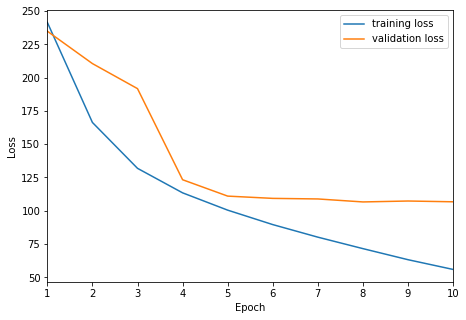

In [35]:
from plot_utils import plot_train_valid_loss

plot_train_valid_loss()

<a id='step3'></a>
## ШАГ 3: Формирование прогнозируемой транскрипции разговорного языка

Конвейер получает на вход выходные данные акустической модели и возвращает прогнозируемую транскрипцию.

Дефолтный файл для распознавания, если не выбран другой

In [94]:
audio_path="audio/3.wav"

Выбор аудиофайла из существующих

In [87]:
import io
import ipywidgets as widgets

uploaded_file = widgets.FileUpload(
    accept='.wav',
    multiple=False
)

uploaded_file

FileUpload(value={}, accept='.wav', description='Upload')

In [ ]:
audio_path = next(iter(uploaded_file.value))

Запись аудиофайла с микрофона

In [86]:
from ipywebrtc import AudioRecorder, CameraStream
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
audio_path="audio/my_record.wav"
recorder.save(audio_path)

Формирование предсказания

In [95]:
from predict import get_predictions

get_predictions(audio_path,
                input_to_softmax=model_end,
                model_path='results/model_final_2020.h5')

--------------------------------------------------------------------------------
at the corder or memered that he had gon away wit out paing fon the te and his naturll impolsed was togoback and remady that ar


Запустите следующую ячейку для того, чтобы прослушать расшифрованную запись

In [96]:
Audio(audio_path)

Построение графика отображения необработанной аудиозаписи и мел-спектрограммы для нее

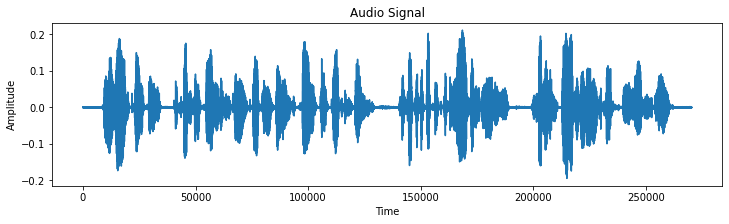

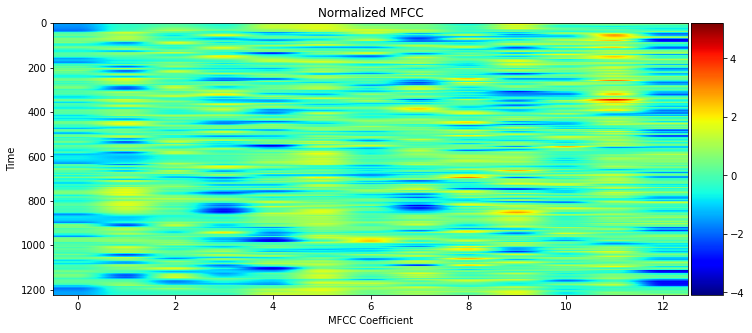

In [75]:
# plot audio signal
plot_raw_audio(audio_path)

# plot normalized mel-spectrogram
plot_mfcc_feature(audio_path)

<a id='conclusion'></a>
## Вывод
В результате эксперимента была протестирован модель для распознавания речи. Она формирует не очень точные предсказания с опечатками и ошибками в словах. Если увеличить объем тестовой выборки, подобрать более подходящие параметры для нейронной сети, можно получить более точные результаты распознавания речи. Но для этого нужны более мощные вычислительные ресурсы.